# **ML Model: Predict Sale Price**

## Objectives

* Fit and evaluate a regression model to predict the Sale Price of a house.

## Inputs

* outputs/datasets/collection/house_prices.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found on its respectives notebooks.

## Outputs

* Train Set (Features and Target)
* Test Set (Features and Target)
* Data Cleaning and Feature Engineering Pipeline
* Modeling Pipeline
* Features Importance Plot

## Additional Comments

In this Notebook we will follow four step to manage achieve our objective:

* Step 1: Load Data
* Step 2: ML Pipeline with all data
* Step 3: Refit pipeline with best features
* Step 4: Push files to Repo


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/data-analytics-housing-project/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/data-analytics-housing-project'

## Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_prices.csv")
)

print(df.shape)
df.head()

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,0.0,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


## ML Pipeline with all data

In [5]:
from sklearn.pipeline import Pipeline

### Data Cleaning
from sklearn.pipeline import Pipeline
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import ArbitraryNumberImputer

### Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine.outliers import Winsorizer
from feature_engine import transformation as vt

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineClf(model):
  pipeline_base = Pipeline([
    # Data Cleaning
    ("CategoricalImputer",CategoricalImputer(imputation_method='missing',fill_value='Unf',
                                                variables=['GarageFinish', 'BsmtFinType1'])),
    
    ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, 
                                                variables=['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF'])),
    
    ("MeanMedianImputer",MeanMedianImputer(imputation_method='median', 
                                                variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])), 
     # Feature Engineer
     ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                variables = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

    ("LogTransformer",vt.LogTransformer(variables = ['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage' ])),

    ("PowerrTransformer",vt.PowerTransformer(variables = ['2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 
                                                            'MasVnrArea', 'OpenPorchSF','TotalBsmtSF', 'WoodDeckSF'])),

    ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, 
                                      variables=['GrLivArea'])),                                                    

    ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", 
                                                        threshold=0.8, selection_method="variance")),
    ("feat_scaling",StandardScaler() ),

    ("feat_selection",SelectFromModel(model) ),

    ("model",model ),  
  ])

  return pipeline_base

/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### ML Pipeline for Modelling and Hyperparameter Optimisation

Custom Class for Hyperparameter Optimization

In [6]:

from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model =  PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

Note: In a future update of the project we will need to modify the pandas package as in the near future pandas will not use anymore pandas.Int64Index.

from pandas import MultiIndex, Int64Index.

In [7]:
from pandas import MultiIndex, Int64Index

/tmp/ipykernel_643/3793995846.py:1: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Split Train and Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'],axis=1),
                                    df['SalePrice'],
                                    test_size = 0.2,
                                    random_state = 0,
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


### Grid Search CV - Sklearn

We will optimize the search using default hyperparameter.

In [9]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Run a GridSearch CV - Binary Classifier

In [10]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and wil

Check the results:

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.714326,0.826957,0.873341,0.057404
2,RandomForestRegressor,0.70525,0.794759,0.836633,0.046156
0,LinearRegression,0.754489,0.790532,0.831704,0.030331
5,GradientBoostingRegressor,0.629836,0.771921,0.827618,0.071977
4,AdaBoostRegressor,0.676189,0.75596,0.802705,0.042531
6,XGBRegressor,0.623751,0.696519,0.748892,0.048599
1,DecisionTreeRegressor,0.494971,0.593073,0.725724,0.082569


An R2 score of at least 0.75 was specified by our client.

ExtraTreesRegressor, RandomForestRegressor, LinearRegression, GradientBoostingRegressor and AdaBoostRegressor currently meet this criteria.

We will proceed with ExtraTreesRegressor that has an R2 of 0.82.


### Extensive Search

We conduct an extensive search on the most suitable model to find the best hyperparameter configuration.

The [Scikit Learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html) notes that: "The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values."

In [12]:
models_search = {
    "ExtraTreesRegressor":ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 300],  
        # This parameter is less prone to overfitting
        'model__max_depth': [None, 3, 10, 20, 40],
        # Too many trees may result in overfitting but too little may not capture the complex patterns
        'model__min_samples_split': [8],  
        # Minimum number of samples required to split a node - 2 allows every node to split.
        # Allowing less splits can control overfitting
        # 'model__min_samples_leaf': [4],  
        # Minimum number of samples required at a leaf node can be flexible (1) and up. It helps to better understand bias and variance
        'model__max_features': ['sqrt', 'log2'],
        # Limits the number of features to consider for each split  
    }
}


### Extensive GridSearch CV

In [13]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

Check results

In [14]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_split,model__n_estimators
14,ExtraTreesRegressor,0.773777,0.849306,0.881622,0.041274,20,log2,8,100
12,ExtraTreesRegressor,0.773777,0.849306,0.881622,0.041274,20,sqrt,8,100
15,ExtraTreesRegressor,0.779563,0.847803,0.880567,0.038534,20,log2,8,300
13,ExtraTreesRegressor,0.779563,0.847803,0.880567,0.038534,20,sqrt,8,300
0,ExtraTreesRegressor,0.776523,0.847613,0.881197,0.03966,None,sqrt,8,100
2,ExtraTreesRegressor,0.776523,0.847613,0.881197,0.03966,None,log2,8,100
18,ExtraTreesRegressor,0.776523,0.847613,0.881197,0.03966,40,log2,8,100
16,ExtraTreesRegressor,0.776523,0.847613,0.881197,0.03966,40,sqrt,8,100
1,ExtraTreesRegressor,0.780135,0.846764,0.881203,0.038222,None,sqrt,8,300
17,ExtraTreesRegressor,0.780135,0.846764,0.881203,0.038222,40,sqrt,8,300


Check the best model

In [15]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

Parameters for the best model

In [16]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 20,
 'model__max_features': 'sqrt',
 'model__min_samples_split': 8,
 'model__n_estimators': 100}

Define the best regressor

In [17]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'EnclosedPorch',
                                                   'MasVnrArea',
                                                   'WoodDeckSF'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['LotFrontage', 'BedroomAbvGr',
                                              'GarageYrBlt'])),
                (...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                

### Assess Feature Importance

* These are the 6 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'YearRemodAdd', 'YearBuilt']


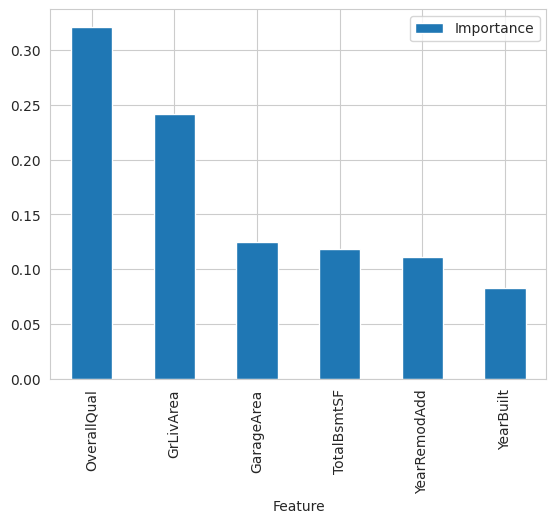

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 8 # how many data cleaning and feature engineering the pipeline has
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()


### Evaluate on Train and Test Sets

In [19]:
from sklearn.metrics import r2_score, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.936
Mean Absolute Error: 12636.401


* Test Set
R2 Score: 0.834
Mean Absolute Error: 19474.637




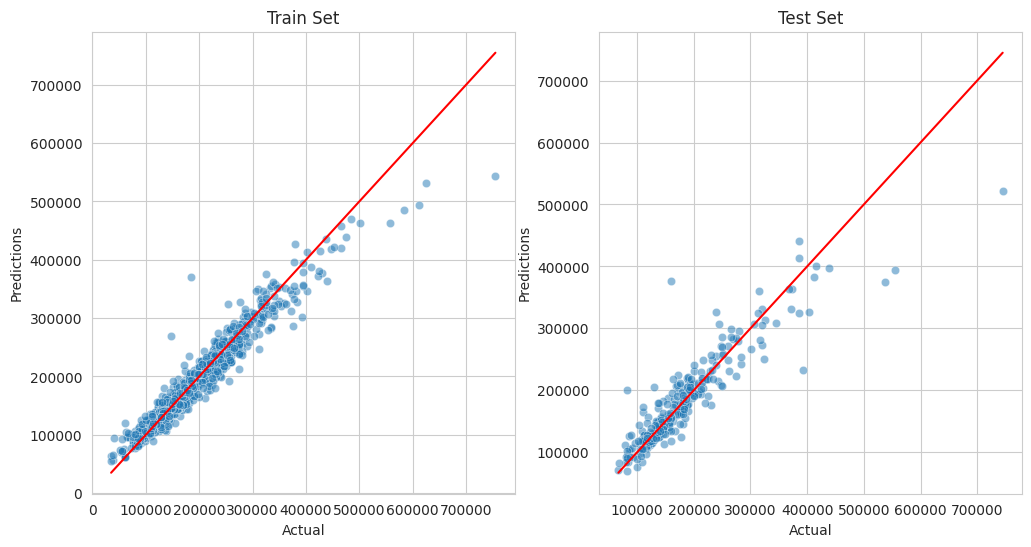

In [20]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### Applying Regressor with PCA

Explore potential values for PCA n_components

In [21]:
pipeline = PipelineClf(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:8])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'],axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 21) 
 <class 'pandas.core.frame.DataFrame'>


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


Apply PCA separately to the scaled data

* The 21 components explain 100.0% of the data 



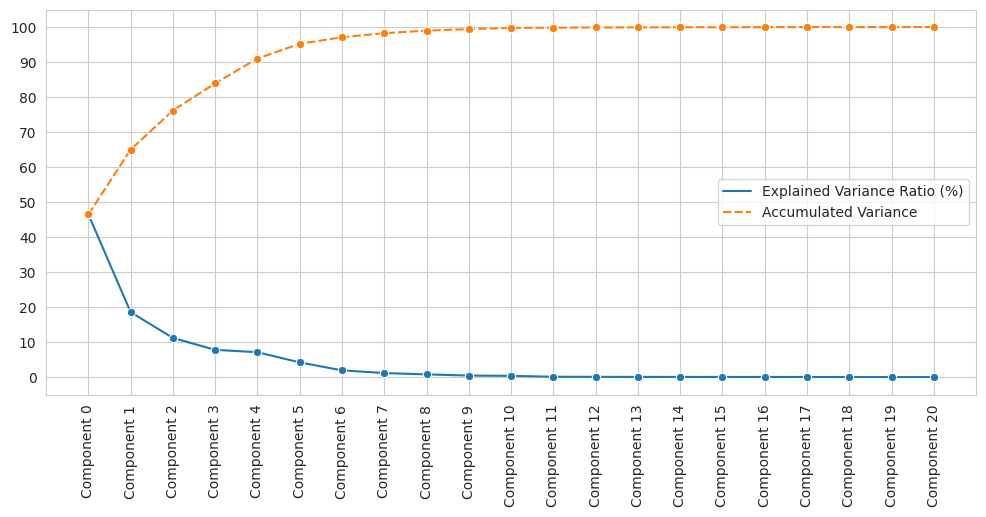

In [22]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 21

def pca_components_analysis(df_pca,n_components): 
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca) # array with transformed PCA

    ComponentsList = ["Component " + str(number) for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data= np.round(100 * pca.explained_variance_ratio_ ,3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum() 

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

    print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12,5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

pca_components_analysis(df_pca=df_pca,n_components=n_components)


We want to have three to four components containing a substantial data variation. Looking at the graph above, four components will cover more than 80% variation, which is satisfactory.

* The 4 components explain 83.92% of the data 



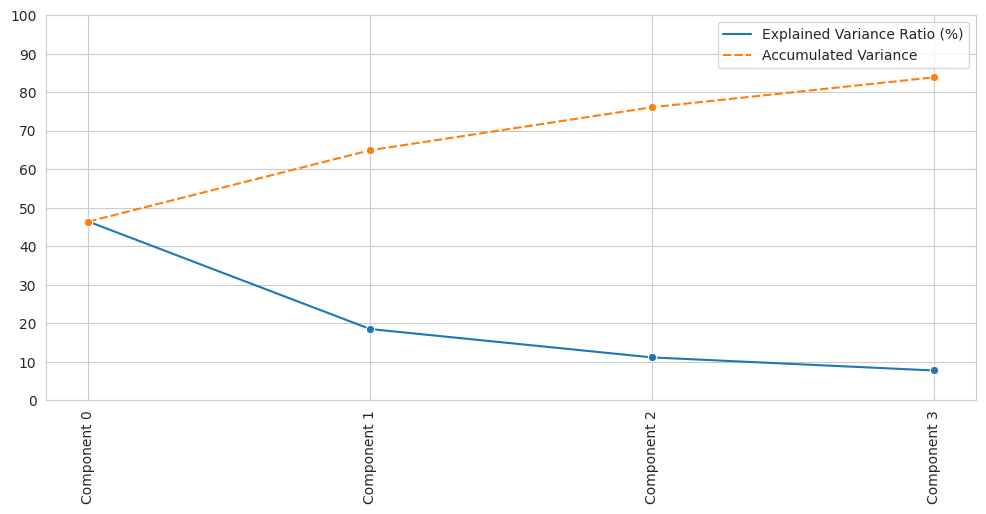

In [23]:
n_components = 4
pca_components_analysis(df_pca=df_pca,n_components=n_components)

### Rewrite ML Pipeline for Modelling

In [24]:
from sklearn.decomposition import PCA

def PipelineClf(model):
  pipeline_base = Pipeline([
    # Data Cleaning
    ("CategoricalImputer",CategoricalImputer(imputation_method='missing',fill_value='Unf',
                                                variables=['GarageFinish', 'BsmtFinType1'])),
    
    ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, 
                                                variables=['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF'])),
    
    ("MeanMedianImputer",MeanMedianImputer(imputation_method='median', 
                                                variables=['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'])), 
     # Feature Engineer
     ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                variables = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

    ("LogTransformer",vt.LogTransformer(variables = ['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage' ])),

    ("PowerTransformer",vt.PowerTransformer(variables = ['2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 
                                                            'MasVnrArea', 'OpenPorchSF','TotalBsmtSF', 'WoodDeckSF'])),

    ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, 
                                      variables=['GrLivArea'])),                                                    

    ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", 
                                                        threshold=0.8, selection_method="variance")),
    ("feat_scaling", StandardScaler()),

    ("PCA", PCA(n_components=4, random_state=0) ), 

    ("model", model),    
  ])

  return pipeline_base

Run Quick Optimization Search

In [25]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

Check results

In [26]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.726085,0.800264,0.862564,0.043802
5,GradientBoostingRegressor,0.617498,0.785421,0.863038,0.086049
3,ExtraTreesRegressor,0.621539,0.781689,0.860249,0.082577
4,AdaBoostRegressor,0.673185,0.768059,0.814817,0.049809
6,XGBRegressor,0.608784,0.767361,0.840812,0.081368
0,LinearRegression,0.699213,0.738479,0.77144,0.032448
1,DecisionTreeRegressor,0.462222,0.601298,0.717288,0.099221


Identify the best model

In [27]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

Parameters for best model

In [28]:
best_parameters

{'model__max_depth': 20,
 'model__max_features': 'sqrt',
 'model__min_samples_split': 8,
 'model__n_estimators': 100}

Define the best regressor

In [29]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('CategoricalImputer',
                 CategoricalImputer(fill_value='Unf',
                                    variables=['GarageFinish',
                                               'BsmtFinType1'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'EnclosedPorch',
                                                   'MasVnrArea',
                                                   'WoodDeckSF'])),
                ('MeanMedianImputer',
                 MeanMedianImputer(variables=['LotFrontage', 'BedroomAbvGr',
                                              'GarageYrBlt'])),
                (...
                                                     'BsmtUnfSF',
                                                     'EnclosedPorch',
                                                     'GarageArea',
                                                     'Garag

### Evaluate Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R2 Score: 0.97
Mean Absolute Error: 8234.525


* Test Set
R2 Score: 0.795
Mean Absolute Error: 23016.926




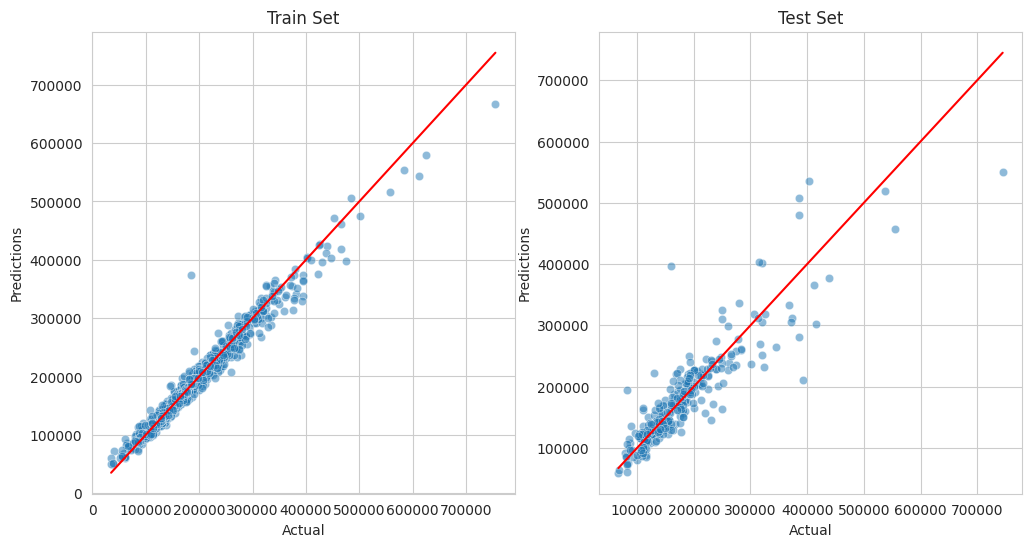

In [30]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

In the Regression Pipeline, the R2 score was above the expected performance threshold (0.7) for the train and test set.

In the Regression with PCA Pipeline the discrepancy between train and test set is worse and appears to be overfitting more than the Regression Pipeline.

## Refit Pipeline with the Best Features

In [31]:
best_features

['GarageArea',
 'GrLivArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

We will add only the feature engineering to the best features:

In [32]:

def PipelineClf(model):
  pipeline_base = Pipeline([

    # Feature Engineering
    ("LogTransformer",vt.LogTransformer(variables = ['GrLivArea'])),

    ("PowerTransformer",vt.PowerTransformer(variables = ['GarageArea', 'TotalBsmtSF'])),

    ("Winsorizer",Winsorizer(capping_method='iqr', tail='both', fold=1.5, 
                                      variables=['GrLivArea'])), 
    # we don't need SmartCorrelatedSelection   

    ("feat_scaling", StandardScaler() ),
    ### feature selection is not needed

    ("model", model ),
       
])

  return pipeline_base

### Split Train Test Sets

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'],axis=1),
                                    df['SalePrice'],
                                    test_size = 0.2,
                                    random_state = 0,
                                    )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 23) (1168,) (292, 23) (292,)


Now we subset the best features:

In [34]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head()

(1168, 6) (1168,) (292, 6) (292,)


,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,774,1828,9,1822,2007,2007
870,308,894,5,894,1962,1962
92,432,964,5,876,1921,2006
817,857,1689,8,1568,2002,2002
302,843,1541,7,1541,2001,2002


###  Grid Seach CV – Sklearn

In [35]:
models_search

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}

Parameters for best model

In [36]:
best_parameters

{'model__max_depth': 20,
 'model__max_features': 'sqrt',
 'model__min_samples_split': 8,
 'model__n_estimators': 100}

In [37]:
params_search = {'ExtraTreesRegressor':  {
    'model__max_depth': [None], 
    'model__min_samples_split': [8],
    'model__n_estimators': [300],        
}
}
params_search

{'ExtraTreesRegressor': {'model__max_depth': [None],
  'model__min_samples_split': [8],
  'model__n_estimators': [300]}}

Now we run a GridSearch CV

In [38]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check Results

In [39]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.739856,0.834265,0.869082,0.048825
3,ExtraTreesRegressor,0.714326,0.830676,0.873341,0.059072
5,GradientBoostingRegressor,0.661577,0.81016,0.861649,0.074712
6,XGBRegressor,0.680809,0.802785,0.852357,0.061943
4,AdaBoostRegressor,0.6648,0.765343,0.812096,0.051578
0,LinearRegression,0.721505,0.757965,0.799486,0.030974
1,DecisionTreeRegressor,0.499289,0.676484,0.736331,0.089614


Check the Best Model

In [40]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

Define the best regression pipeline

In [41]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('LogTransformer', LogTransformer(variables=['GrLivArea'])),
                ('PowerTransformer',
                 PowerTransformer(variables=['GarageArea', 'TotalBsmtSF'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['GrLivArea'])),
                ('feat_scaling', StandardScaler()),
                ('model', RandomForestRegressor(random_state=0))])

### Assess Feature Importance

* These are the 6 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'YearBuilt', 'YearRemodAdd']


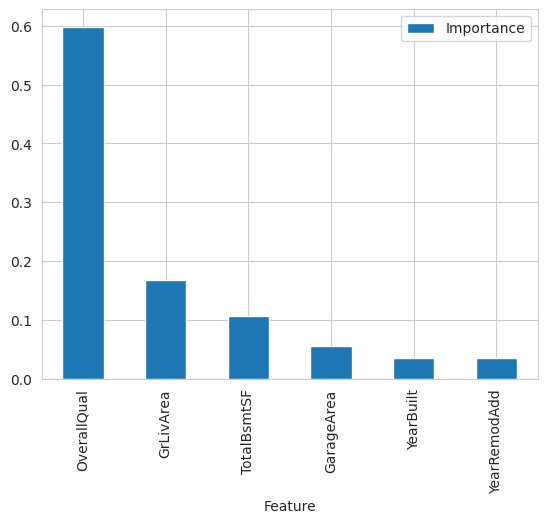

In [42]:
data_cleaning_feat_eng_steps = 1 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng,
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

---

# Push files to Repo

* Train set
* Test set
* Modeling pipeline
* Features importance plot

In [43]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)


#### Train Set : Features and Target

In [44]:
X_train.head()

,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,774,1828,9,1822,2007,2007
870,308,894,5,894,1962,1962
92,432,964,5,876,1921,2006
817,857,1689,8,1568,2002,2002
302,843,1541,7,1541,2001,2002


In [45]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [46]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [47]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

#### Test Set: Features and Target

In [48]:
X_test.head()

,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
529,484,2515,6,2035,1957,1975
491,240,1578,6,806,1941,1950
459,352,1203,5,709,1950,1950
279,505,2022,7,1160,1977,1977
655,264,1092,6,525,1971,1971


In [49]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [50]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [51]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

#### Modelling Pipeline

This will be the ML Pipeline for predicting Sale Price

In [52]:
best_regressor_pipeline

Pipeline(steps=[('LogTransformer', LogTransformer(variables=['GrLivArea'])),
                ('PowerTransformer',
                 PowerTransformer(variables=['GarageArea', 'TotalBsmtSF'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['GrLivArea'])),
                ('feat_scaling', StandardScaler()),
                ('model', RandomForestRegressor(random_state=0))])

In [53]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_sale_price/v1/best_regressor_pipeline.pkl']

#### Feature Importance Plot

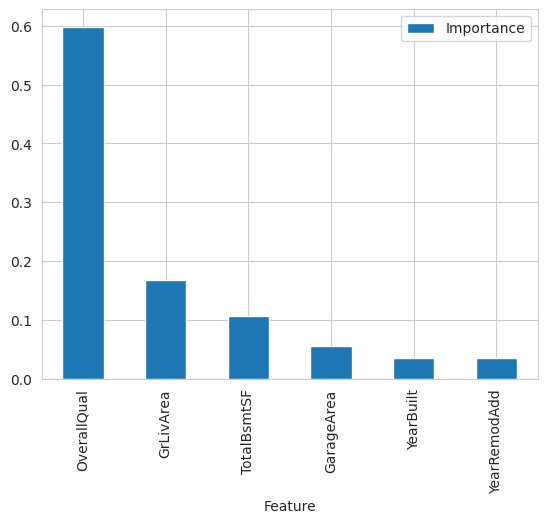

In [54]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

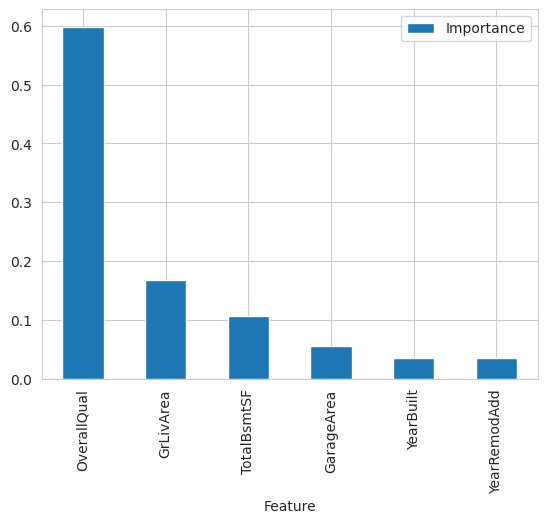

In [55]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')